Average error: 9.101336791849844
Average PCE absolute difference: 0.554220345833333


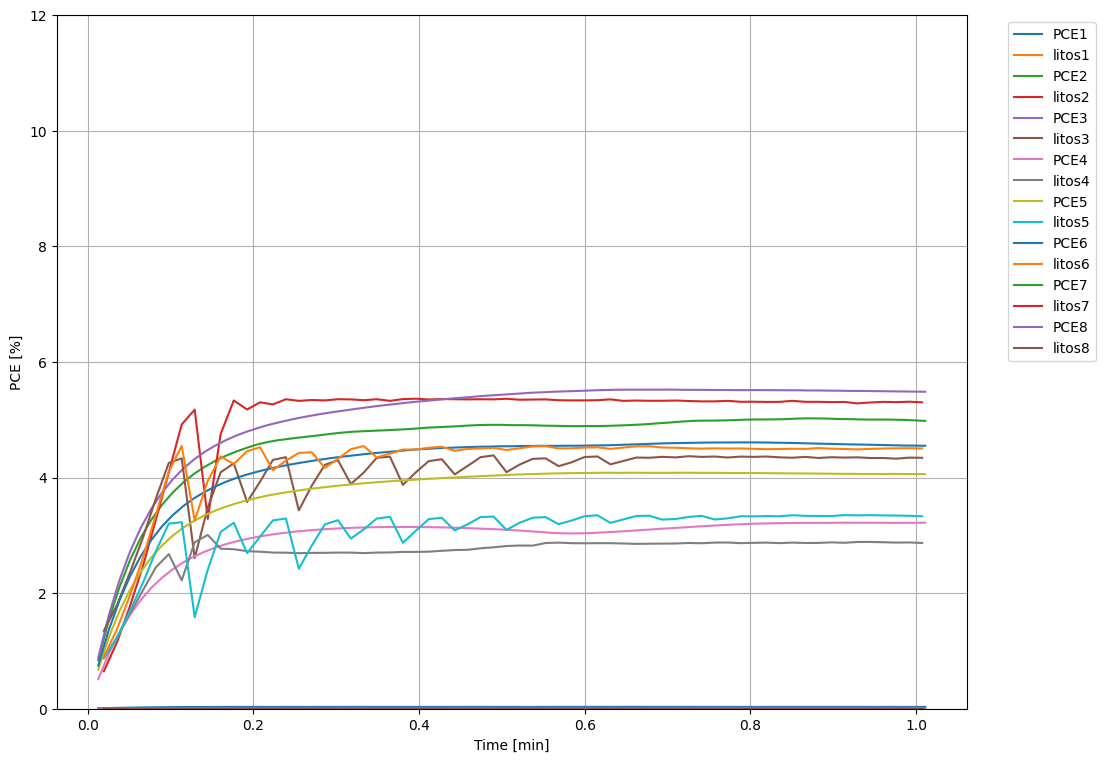

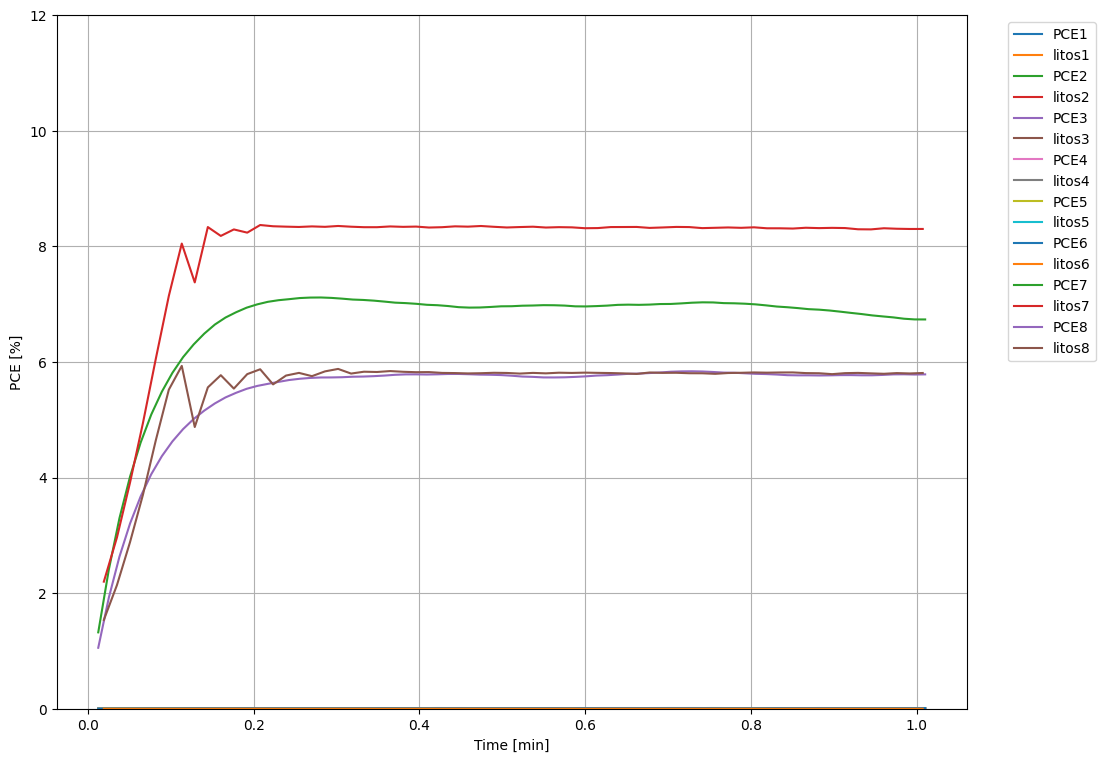

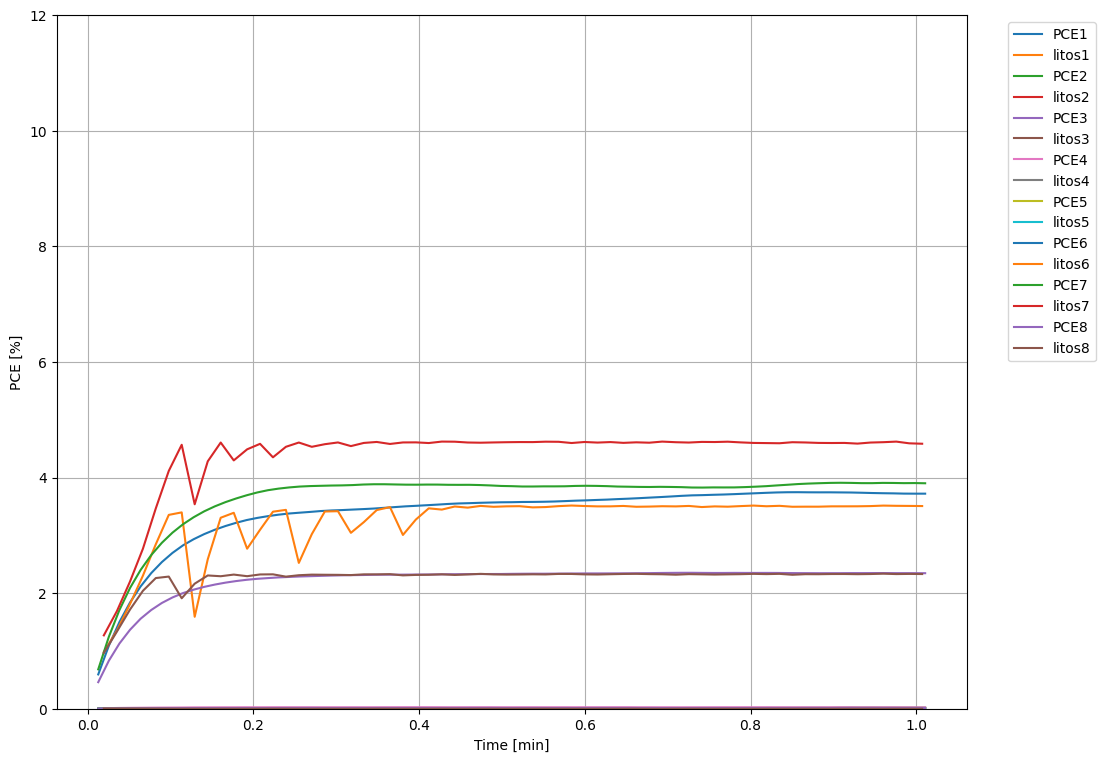

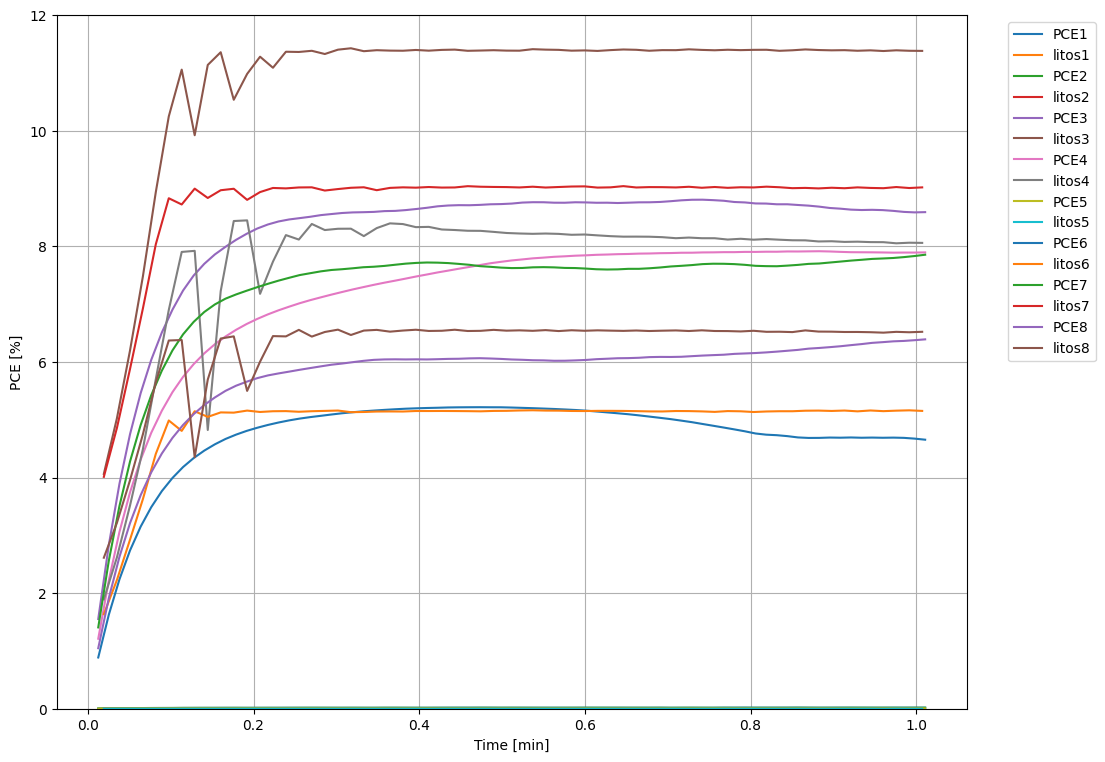

In [86]:
import matplotlib.pyplot as plt
import numpy as np
import numpy_indexed as npi
from labellines import labelLines
from matplotlib.font_manager import FontProperties
import os
import sys
import re

def plot_difference(litos_directory, ss_file_path):
    # litos_directory = ""
    # litos_directory = r"C:\Users\achen\Dropbox\code\Stability-Setup\data\Mar-4-2025 4 device test\2025-03-04-- Litos New PCB 4 Device comparison\devices\device_2"

    all_files = []

    if litos_directory != "":
        for root, dirs, files in os.walk(litos_directory):
            for file in files:
                if file.endswith('.csv'):
                    file_path = os.path.join(root, file)
                    all_files.append(file_path)

    litos_pce = []
    litos_time = []

    # Process each file
    for file_path in all_files:
        if "_2_0" in file_path:
            try:
                data = np.genfromtxt(
                    file_path,
                    delimiter=',',
                    comments='#',
                    skip_header=0,
                    encoding='cp1252'  # Specify the correct encoding
                )
                pce = ((data[:, 1] * (data[:, 2]/1000)) / (0.1*0.128))*100
                # data_with_pce= np.column_stack((data, pce))
                litos_time.append(data[:,0])
                litos_pce.append(pce)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
    pce = []
    for file_path in all_files:
        if "_2_0" in file_path:
            try:
                with open(file_path, 'r', encoding='cp1252') as f:
                    all_lines = f.readlines()

                comment_lines = [line.strip() for line in all_lines if "PCE" in line.lstrip()]
                pce.append([float(re.search(r'([\d\.]+)', s).group(1)) for s in comment_lines if re.search(r'([\d\.]+)', s)][0])

            except Exception as e:
                print(f"Error processing {file_path}: {e}")

    litos_pce = litos_pce[::-1]
    litos_time = litos_time[::-1]
    litos_time = [val/60 for val in litos_time]

    data = []
    # ss_file_path = ""
    # ss_file_path = r"C:\Users\achen\Dropbox\code\Stability-Setup\data\Mar-4-2025 4 device test\Mar-04-2025 16_42_19__4 Device First Test\Mar-04-2025_16-44-53__4 Device First Test__ID2__mppt.csv"
    if ss_file_path != "":
        arr = np.loadtxt(ss_file_path, delimiter=",", dtype=str)
        header_row = np.where(arr == "Time")[0][0]

        meta_data = {}
        for data in arr[:header_row, :2]:
            meta_data[data[0]] = data[1]

        headers = arr[header_row, :]
        arr = arr[header_row + 1 :, :]

        header_dict = {value: index for index, value in enumerate(headers)}
        pce_indices = [header_dict[key] for key in header_dict if "PCE" in key]

        time = np.array(arr[:, header_dict["Time"]]).astype("float")
        time /= 60

        # Convert any non-numeric values.
        pce_list = np.array(arr)
        for i in range(len(pce_list)):
            pce_list[i] = [
                float(j) if j.strip() not in ["ovf", "nan"] else 0.0
                for j in pce_list[i]
            ]

        pce_list = pce_list.astype(float)
        data = pce_list[:, pce_indices]

        # because 2 minute trial
        # half_len = len(data) // 2
        # pce_list = pce_list[half_len:, :]
        # time = time[half_len:]
        # start_time = min(time)
        # time -= start_time
        # data = data[half_len:, :]
        # data *= 2.048 # comment line if not using mask
    # print(pce_list)
    pce_list = np.flip(pce_list, axis=1)
    # min_time = min(time)*0.99
    # max_time = max(time)*1.01
    plot_size = (12,8)
    min_pce = 0
    max_pce = 12

    plt.figure(figsize=plot_size)
    # plt.xlim(min_time,max_time)
    plt.ylim(bottom = min_pce, top = max_pce)
    plt.xlabel('Time [min]')
    plt.grid()

    plt.ylabel('PCE [%]')
    plt.subplots_adjust(left=0.086,
                        bottom=0.06,
                        right=0.844,
                        top=0.927,
                        wspace=0.2,
                        hspace=0.2)

    x_start = 0
    x_end = max(time)

    errors = []
    average_litos = []
    average = []
    for i in range(8):
        lineName = "PCE" + str(i + 1)
        if ss_file_path:
            plt.plot(time,data[:,i], label = lineName)
        if True:
            # plt.hlines(pce[i], x_start, x_end, label="litos_pce" + str(i + 1))
            plt.plot(litos_time[i], litos_pce[i], label = "litos" + str(i+1))
        if ss_file_path and True:
            second_half = data[:,i][len(data[:,i]) // 2:]
            average_second_half = np.mean(second_half)

            average_second_half_litos = pce[i]
            # second_half_litos = litos_pce[i][len(litos_pce[i]) // 2:]
            # average_second_half_litos = np.mean(second_half_litos)

            # print(i, percent_error, average_second_half, average_second_half_litos)
            # print(average_second_half, average_second_half_litos)
            if average_second_half > 1:
                average.append(average_second_half)
            if average_second_half_litos > 1:
                average_litos.append(average_second_half_litos)

    average_second_half = np.mean(average)
    average_second_half_litos = np.mean(average_litos)
    percent_error = abs(average_second_half - average_second_half_litos) / abs(average_second_half_litos) * 100
    abs_diff = abs(average_second_half - average_second_half_litos)
    # print(percent_error, abs_diff)

    lines = plt.gca().get_lines()
    x_min, x_max = plt.xlim()
    num_lines = len(lines)
    plt.legend(bbox_to_anchor=(1.15, 1))

    return (percent_error, abs_diff)

files = [[r"C:\Users\achen\Dropbox\code\Stability-Setup\data\Mar-4-2025 4 device test\2025-03-04-- Litos New PCB 4 Device comparison\devices\device_1",
                r"C:\Users\achen\Dropbox\code\Stability-Setup\data\Mar-4-2025 4 device test\Mar-04-2025 16_42_19__4 Device First Test\Mar-04-2025_16-44-53__4 Device First Test__ID1__mppt.csv"],
         [r"C:\Users\achen\Dropbox\code\Stability-Setup\data\Mar-4-2025 4 device test\2025-03-04-- Litos New PCB 4 Device comparison\devices\device_2",
                r"C:\Users\achen\Dropbox\code\Stability-Setup\data\Mar-4-2025 4 device test\Mar-04-2025 16_42_19__4 Device First Test\Mar-04-2025_16-44-53__4 Device First Test__ID2__mppt.csv"],
         [r"C:\Users\achen\Dropbox\code\Stability-Setup\data\Mar-4-2025 4 device test\2025-03-04-- Litos New PCB 4 Device comparison\devices\device_3",
                r"C:\Users\achen\Dropbox\code\Stability-Setup\data\Mar-4-2025 4 device test\Mar-04-2025 16_42_19__4 Device First Test\Mar-04-2025_16-44-53__4 Device First Test__ID3__mppt.csv"],
         [r"C:\Users\achen\Dropbox\code\Stability-Setup\data\Mar-4-2025 4 device test\2025-03-04-- Litos New PCB 4 Device comparison\devices\device_4",
                r"C:\Users\achen\Dropbox\code\Stability-Setup\data\Mar-4-2025 4 device test\Mar-04-2025 16_42_19__4 Device First Test\Mar-04-2025_16-44-53__4 Device First Test__ID4__mppt.csv"]]

errors = []
diffs = []
for litos, ss_file in files:
    percent_error, abs_diff = plot_difference(litos, ss_file)
    errors.append(percent_error)
    diffs.append(abs_diff)
    # print(percent_error, abs_diff)


print(f"Average error: {np.mean(errors)}")
print(f"Average PCE absolute difference: {np.mean(diffs)}")


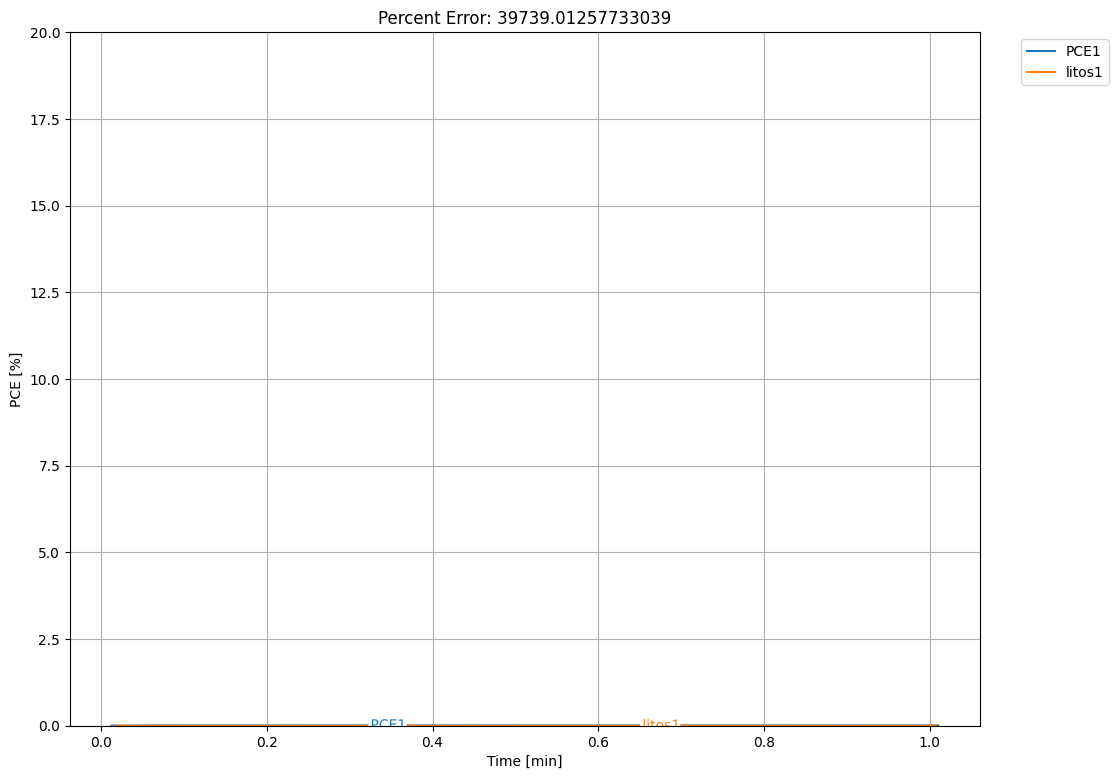

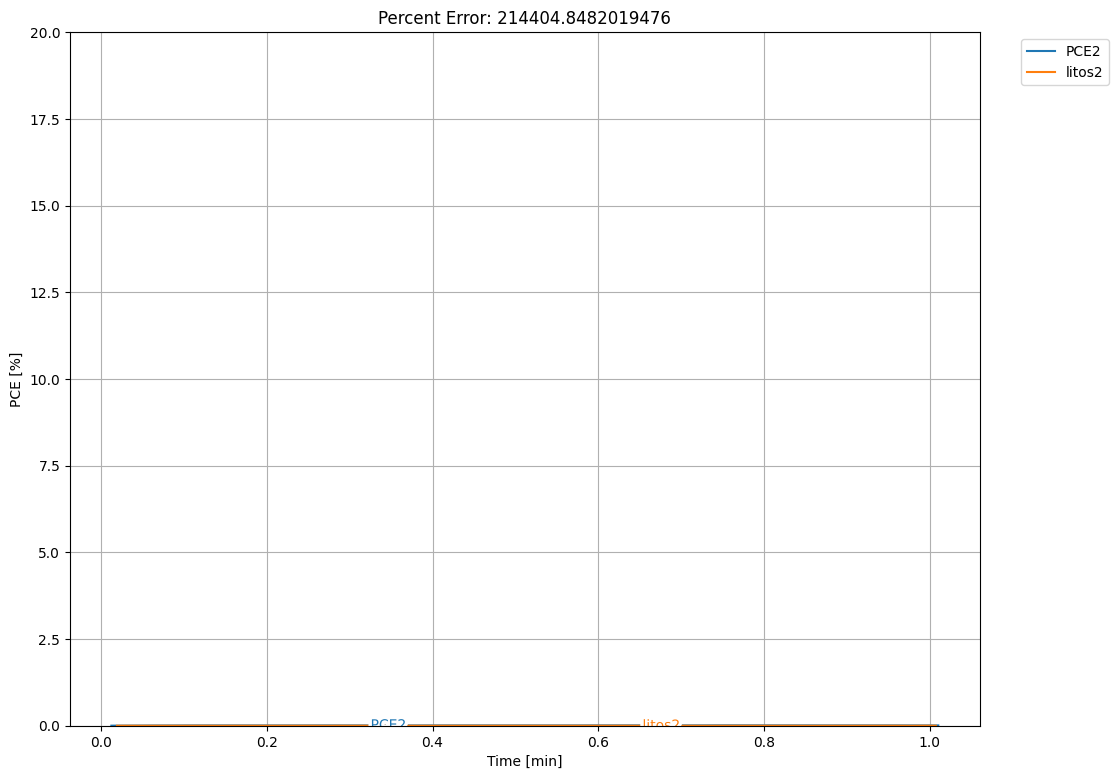

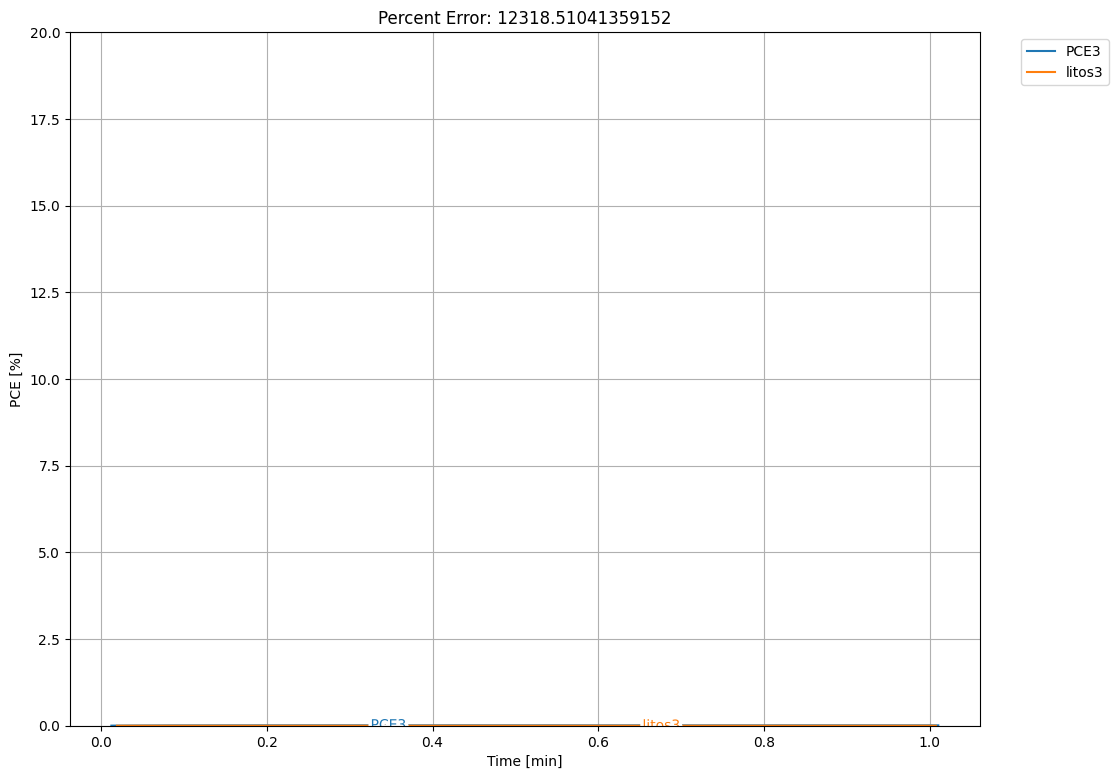

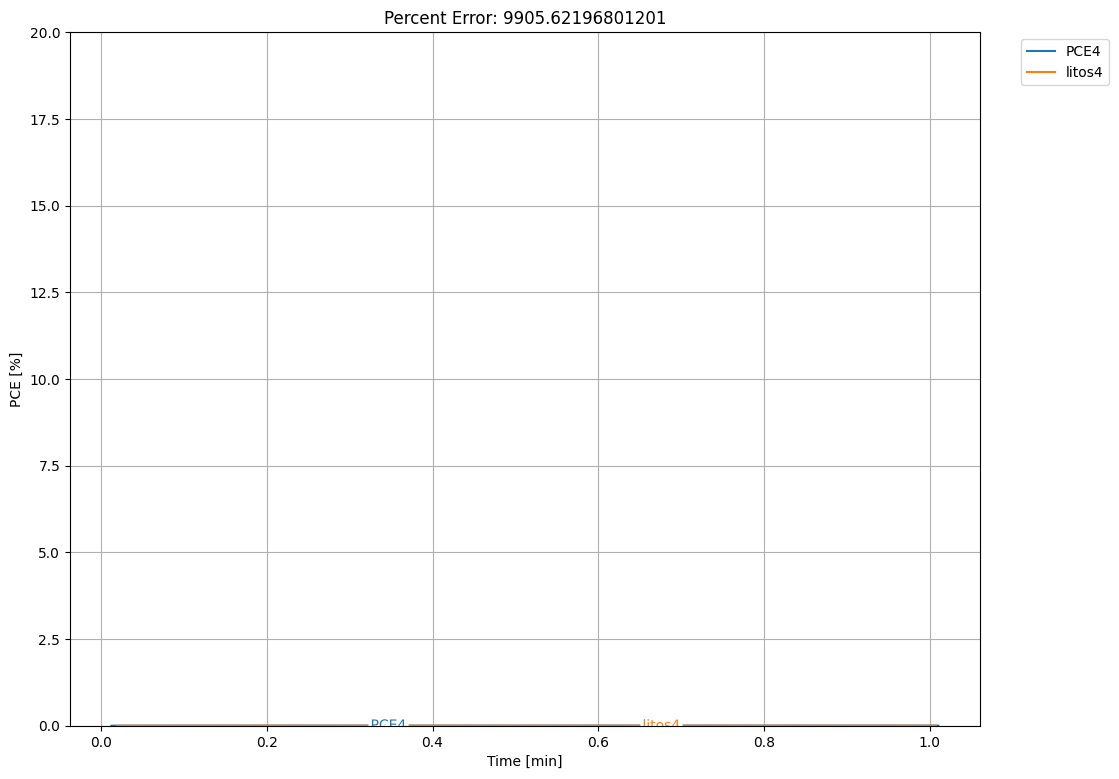

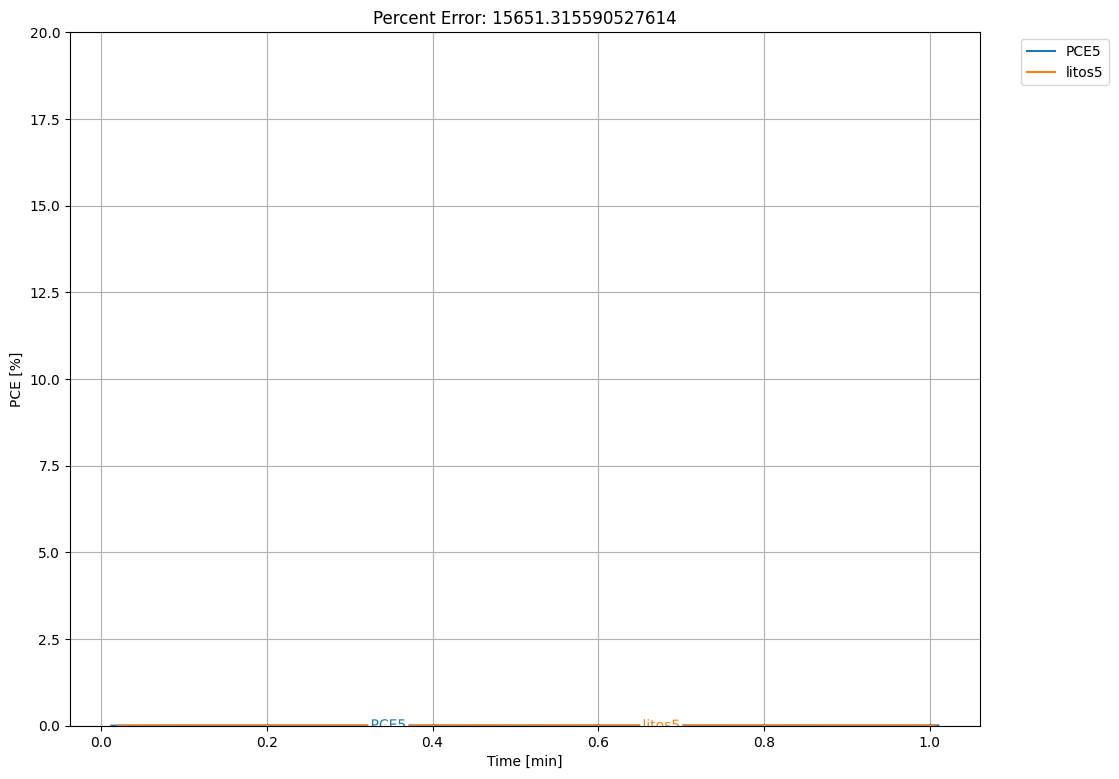

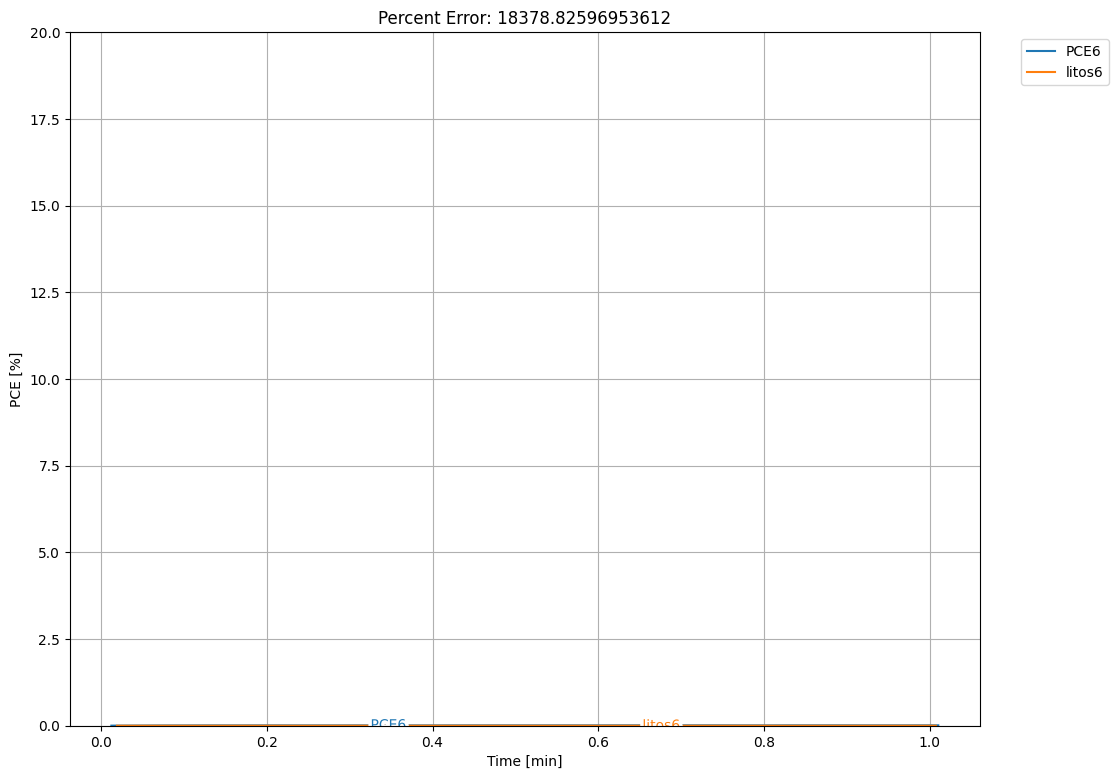

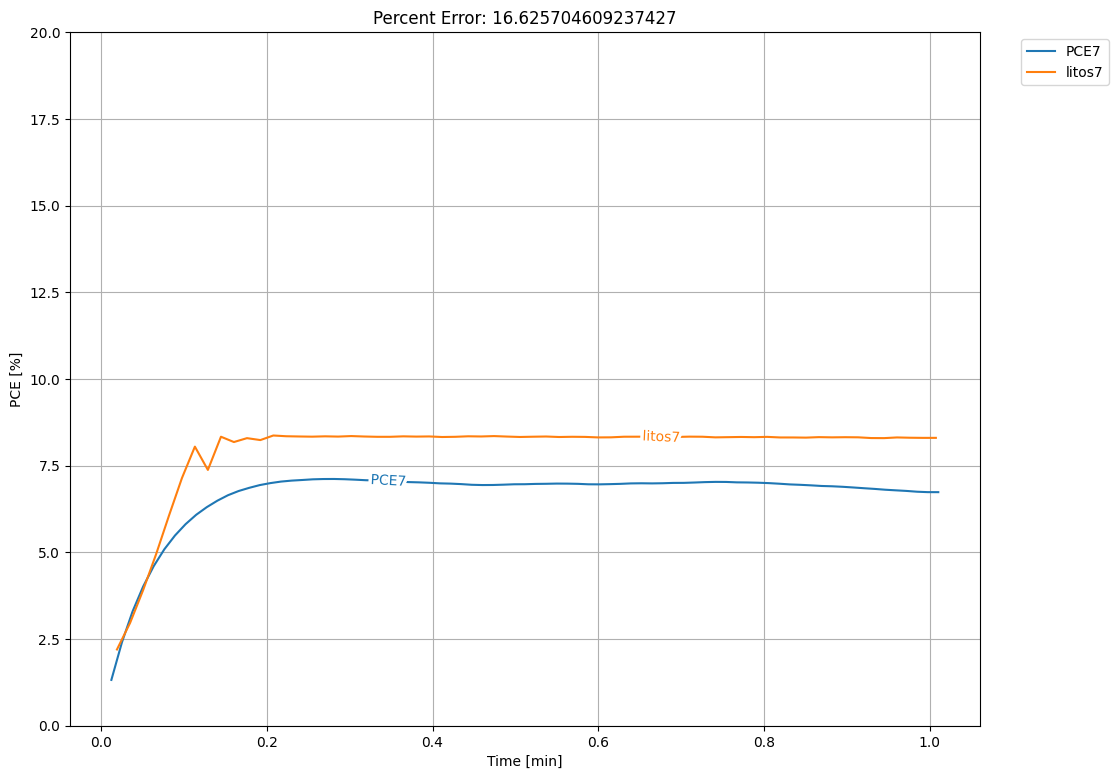

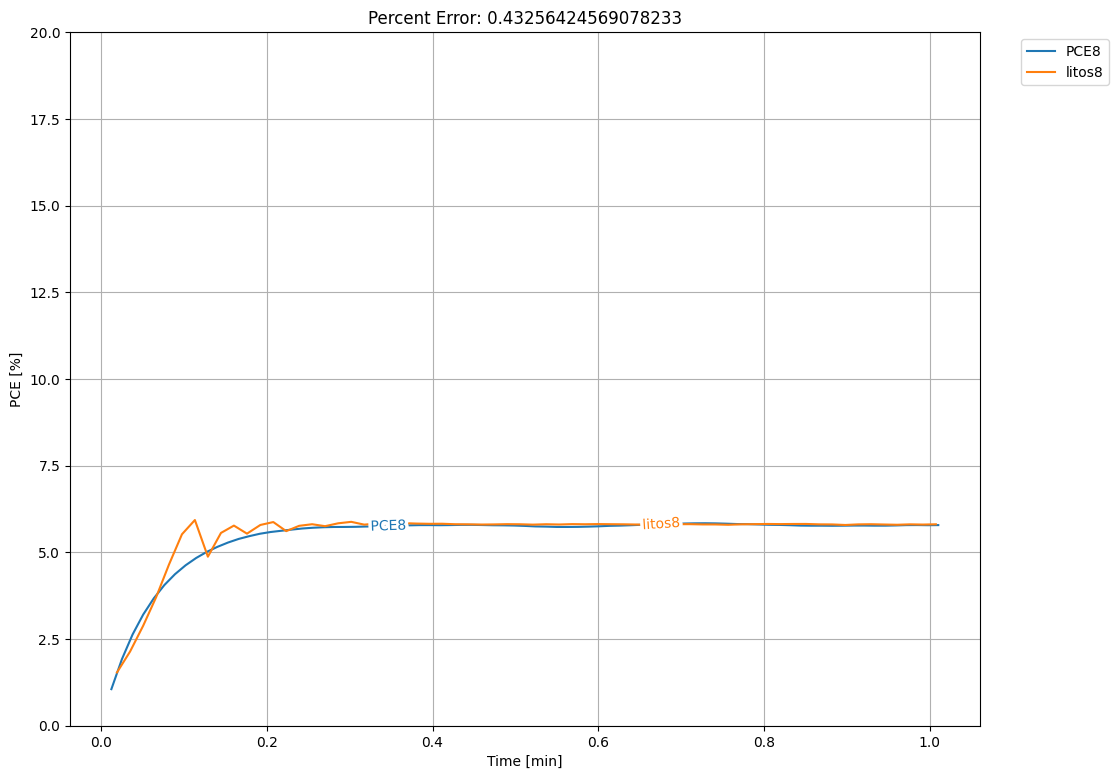

In [74]:
errors = []
for i in range(8):
    plt.figure(figsize=plot_size)
    plt.ylim(bottom = -0, top = max_pce)
    plt.xlabel('Time [min]')
    plt.grid()

    plt.ylabel('PCE [%]')
    plt.subplots_adjust(left=0.086,
                        bottom=0.06,
                        right=0.844,
                        top=0.927,
                        wspace=0.2,
                        hspace=0.2)
    percent_error = float("inf")

    lineName = "PCE" + str(i + 1)
    if ss_file_path:
        plt.plot(time,data[:,i], label = lineName)
    if litos_time:
        plt.plot(litos_time[i], litos_pce[i], label = "litos" + str(i+1))
    if ss_file_path and litos_time:
        second_half_litos = litos_pce[i][len(litos_pce[i]) // 2:]
        average_second_half_litos = np.mean(second_half_litos)

        second_half = data[:,i][len(data[:,i]) // 2:]
        average_second_half = np.mean(second_half)

        percent_error = abs(average_second_half - average_second_half_litos) / abs(average_second_half_litos) * 100

    labelLines(plt.gca().get_lines(), zorder=2.5)
    plt.title("Percent Error: "+ str(percent_error))
    plt.legend(bbox_to_anchor=(1.15, 1))
for idx, i in enumerate(errors):
    print(idx+1, i)

In [39]:

litos_directory = ""
litos_directory = r"C:\Users\achen\Dropbox\code\Stability-Setup\data\Mar-4-2025 4 device test\2025-03-04-- Litos New PCB 4 Device comparison\devices\device_4"

all_files = []

if litos_directory != "":
    for root, dirs, files in os.walk(litos_directory):
        for file in files:
            if file.endswith('.csv'):
                file_path = os.path.join(root, file)
                all_files.append(file_path)


litos_pce = []
litos_time = []

# Process each file



[6.518277]
[9.018055]
[5.157342]
[7.2e-05]
[8.05806]
[11.385308]
[5.2e-05]
[0.000312]


[11.980489822356686, 10.445676157590675, 11.818839911303405, 11.451331187836963, 11.981287720383836, 12.83199561297592, 12.493401470866804, 2.1745197361680322e-05]
[11.2520239349781, 8.896264341297515, 10.04067553057723, 9.59906903408312, 9.99953655116765, 2.6051065573770492e-05, 9.573134899719518, 1.1501721311475273e-06]
[11.980489822356686, 11.2520239349781]
[10.445676157590675, 8.896264341297515]
[11.818839911303405, 10.04067553057723]
[11.451331187836963, 9.59906903408312]
[11.981287720383836, 9.99953655116765]
[12.83199561297592, 2.6051065573770492e-05]
[12.493401470866804, 9.573134899719518]
[2.1745197361680322e-05, 1.1501721311475273e-06]
nan


C:\Users\achen\AppData\Local\Temp\ipykernel_23472\2928003868.py:112: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if data != []:
c:\Users\achen\miniforge3\envs\stabilitySetup\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\achen\miniforge3\envs\stabilitySetup\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


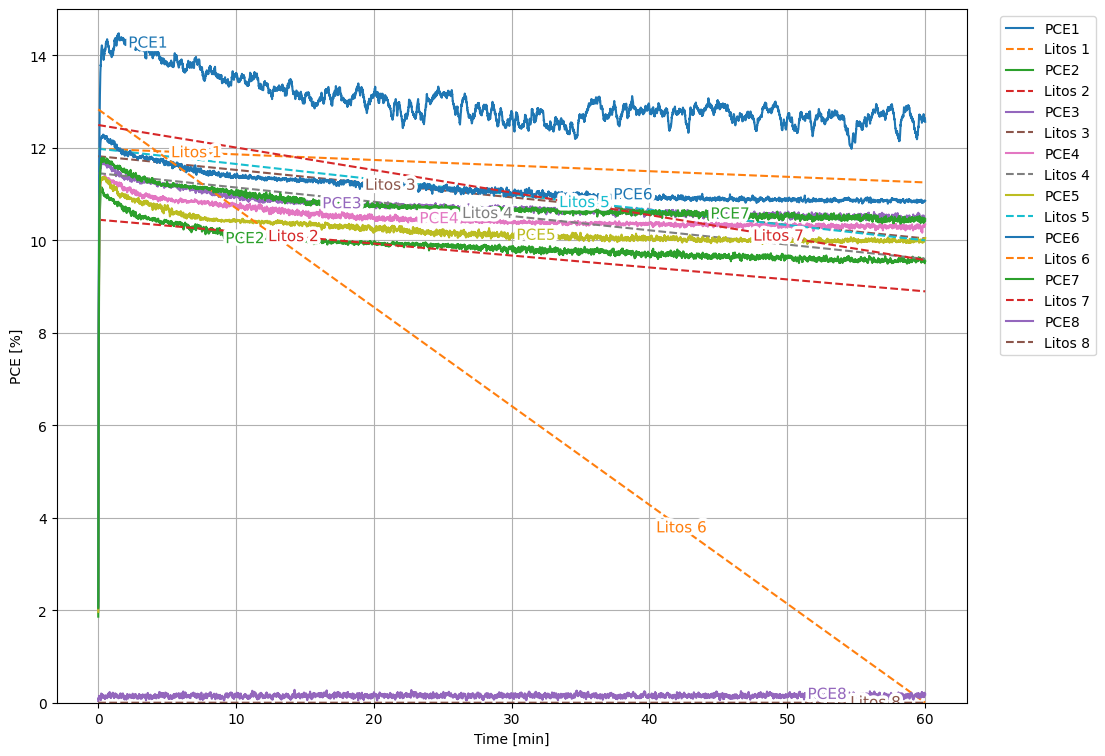

In [50]:
#plot litos uneven length

litos_directory = ""
litos_directory = r"C:\Users\achen\Dropbox\code\Stability-Setup\data\2024-11-06 --litos vs stability setup long test\nov6_2024 test 1\devices"



def process_files(litos_directory, all_files, pattern):
    all_files = []

    if litos_directory != "":
        for root, dirs, files in os.walk(litos_directory):
            for file in files:
                if file.endswith('.csv'):
                    file_path = os.path.join(root, file)
                    all_files.append(file_path)

    times = []
    pces = []
    for file_path in all_files:
        if pattern in file_path:
            try:
                data = np.genfromtxt(
                    file_path,
                    delimiter=',',
                    comments='#',
                    skip_header=0,
                    encoding='cp1252'  # Specify the correct encoding
                )
                pce = (data[:, 1] * data[:, 2] / 1000) / (0.1 * 0.128) * 100
                times.append(data[:, 0])
                pces.append(pce)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

    pces = pces[::-1]
    return times, pces

def calculate_second_half_averages(pces):
    averages = []
    for pce in pces[:8]:  # Limit to first 8 files, as per the original code
        second_half = pce[len(pce) // 2:]
        averages.append(np.mean(second_half))
    return averages

# Process files for each pattern
litos_time1, litos_pce1 = process_files(litos_directory, all_files, "_3_0")
litos_time2, litos_pce2 = process_files(litos_directory, all_files, "_7_0")

# Calculate averages for each pattern
litos_beginning_avg = calculate_second_half_averages(litos_pce1)
litos_ending_avg = calculate_second_half_averages(litos_pce2)

print(litos_beginning_avg)
print(litos_ending_avg)


data = []

ss_file_path = ""
ss_file_path = r"C:\Users\achen\Dropbox\code\Stability-Setup\data\2024-11-06 --litos vs stability setup long test\Nov-06-2024 13_50_53\Nov-06-2024 13_50_53ID2PnO.csv"
if ss_file_path != "":
    arr = np.loadtxt(ss_file_path,
                        delimiter=",",
                        dtype=str)


    headers = arr[6,:]
    header_dict = {value: index for index, value in enumerate(headers)}
    pce_indicies = [header_dict[value] for value in header_dict if "PCE" in value]
    arr = arr[7:, :]

    time = np.array(arr[:,header_dict["Time"]]).astype('float')
    time/=60
    pce_list = np.array(arr)
    pce_list = pce_list[:, pce_indicies]
    # pce_list = pce_list[:,0:-1]
    for i in range(len(pce_list)):
        pce_list[i] = [float(j) if j != " ovf" else 0.0 for j in pce_list[i]]
        pce_list[i] = [float(j) if j != "nan" else 0.0 for j in pce_list[i]]

    pce_list = pce_list.astype(float)

    data = pce_list #np.array(data).T
    # data *= 2.048 # comment line if not using mask

# min_time = min(time)*0.99
# max_time = max(time)*1.01
plot_size = (12,8)
min_pce = 0
max_pce = 15

plt.figure(figsize=plot_size)
# plt.xlim(min_time,max_time)
plt.ylim(bottom = min_pce, top = max_pce)
plt.xlabel('Time [min]')
plt.grid()

plt.ylabel('PCE [%]')
plt.subplots_adjust(left=0.086,
                    bottom=0.06,
                    right=0.844,
                    top=0.927,
                    wspace=0.2,
                    hspace=0.2)

errors = []

for i in range(8):
    lineName = "PCE" + str(i + 1)
    # print(np.array(pce_list[i]))
    if data != []:
        plt.plot(time,data[:,i], label = lineName)
    if i < len(litos_beginning_avg) and i < len(litos_ending_avg):
        # Calculate straight line
        y_values = [
            litos_beginning_avg[i],
            litos_ending_avg[i]
        ]
        print(y_values)
        x_values = [time[0], time[-1]]
        plt.plot(x_values, y_values, linestyle="--", label=f"Litos {i + 1}")

print(np.mean(errors))

lines = plt.gca().get_lines()
x_min, x_max = plt.xlim()
num_lines = len(lines)
xvals = np.linspace(x_min + 0.1 * (x_max - x_min), x_max - 0.1 * (x_max - x_min), num_lines)
bold_font = FontProperties(weight='medium')
labelLines(
    lines,
    xvals=xvals,
    zorder=2.5,
    align=False,
    fontsize=11,
    fontproperties=bold_font
)
plt.legend(bbox_to_anchor=(1.15, 1))


5.702184461254767
1 11.712155552192428
2 7.597715714838777
3 4.563543000435888
4 7.159613916019965
5 0.08828099545398294
6 41636914.98210712
7 9.101768679525222
8 14331051.566674741


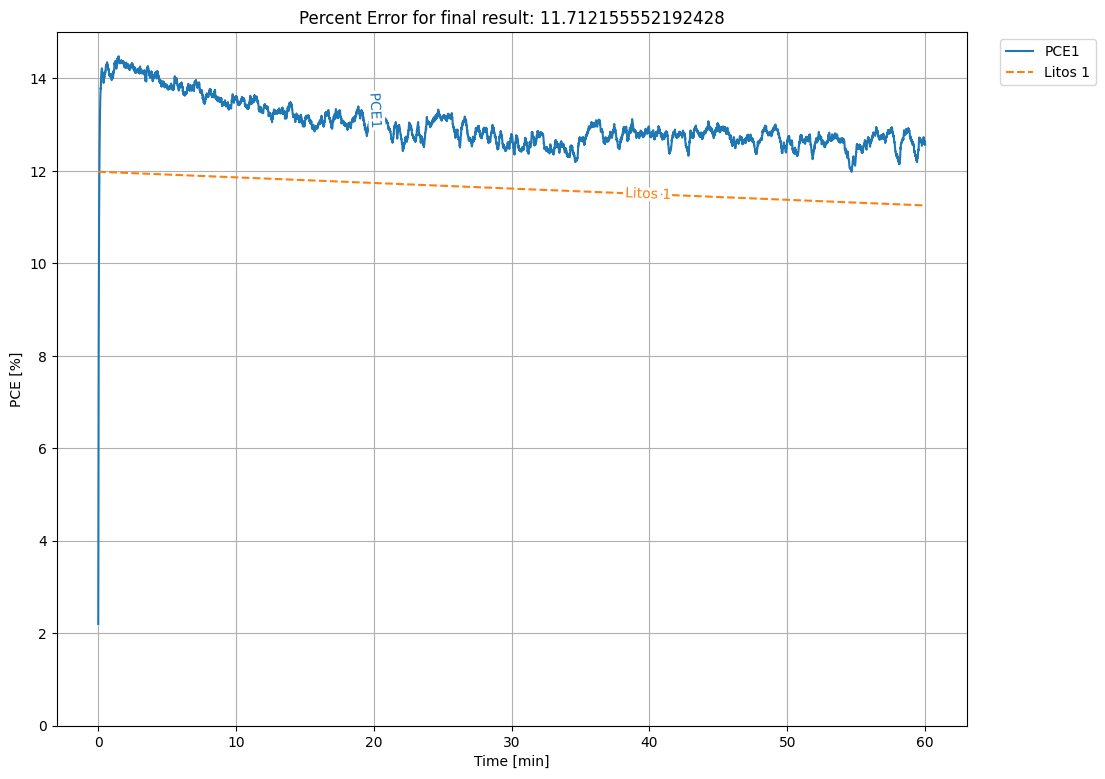

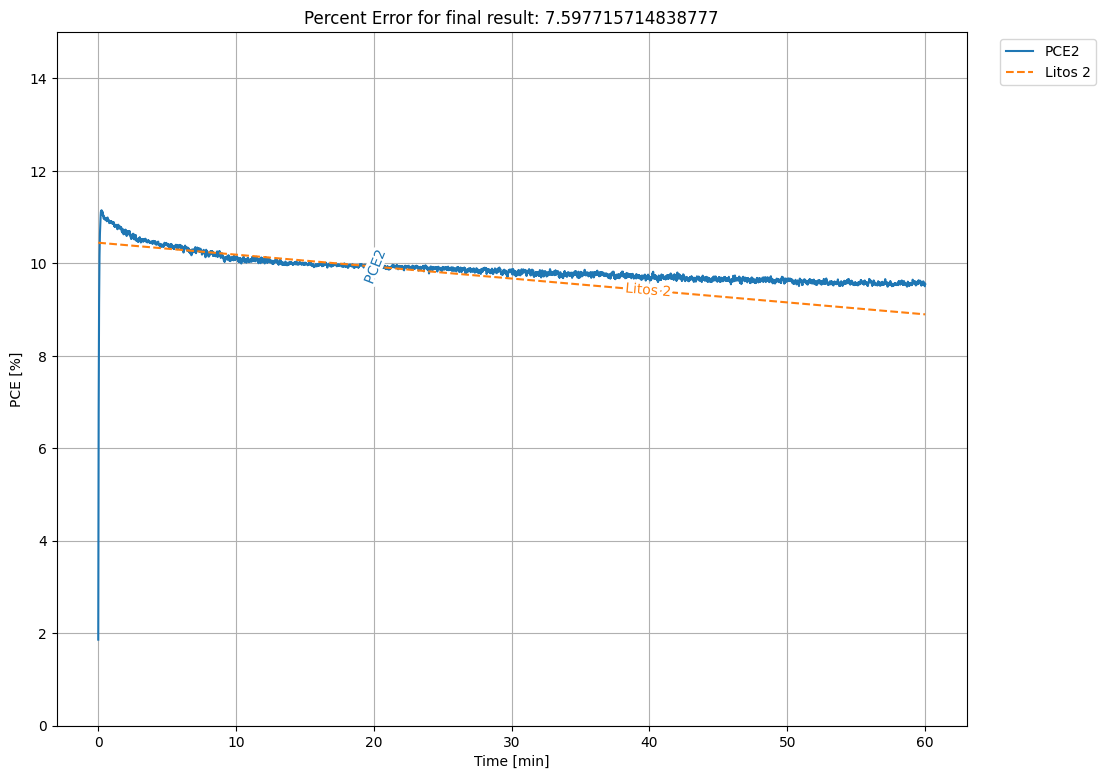

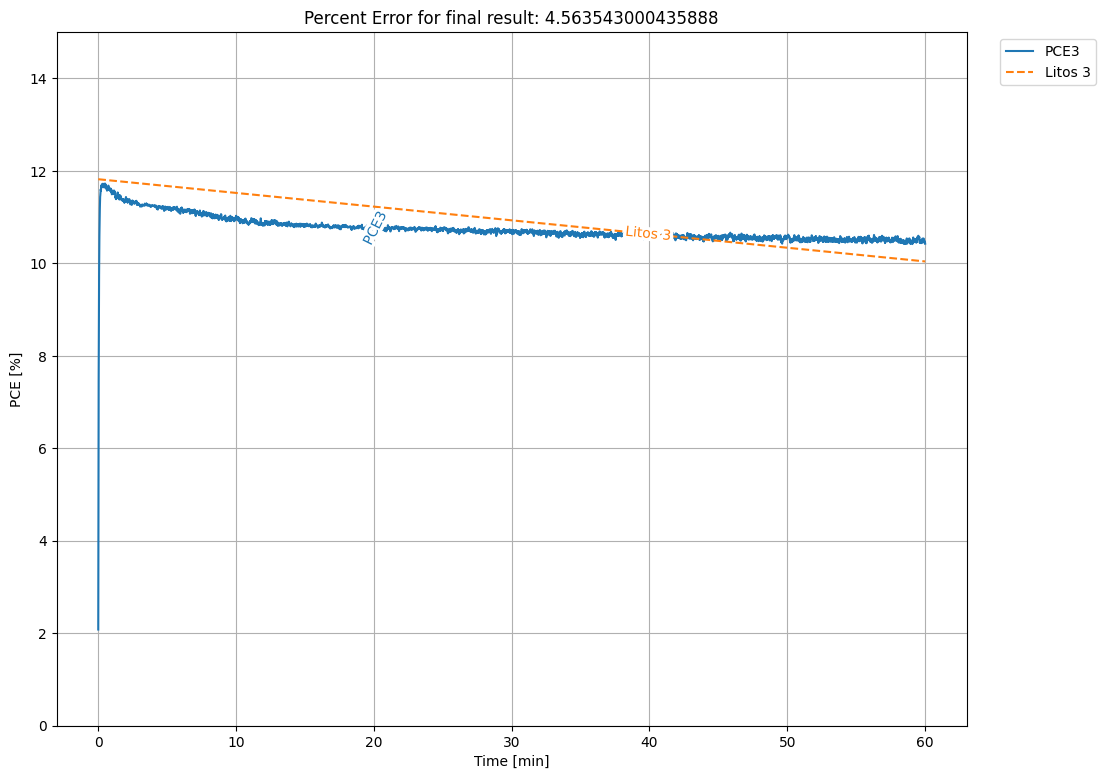

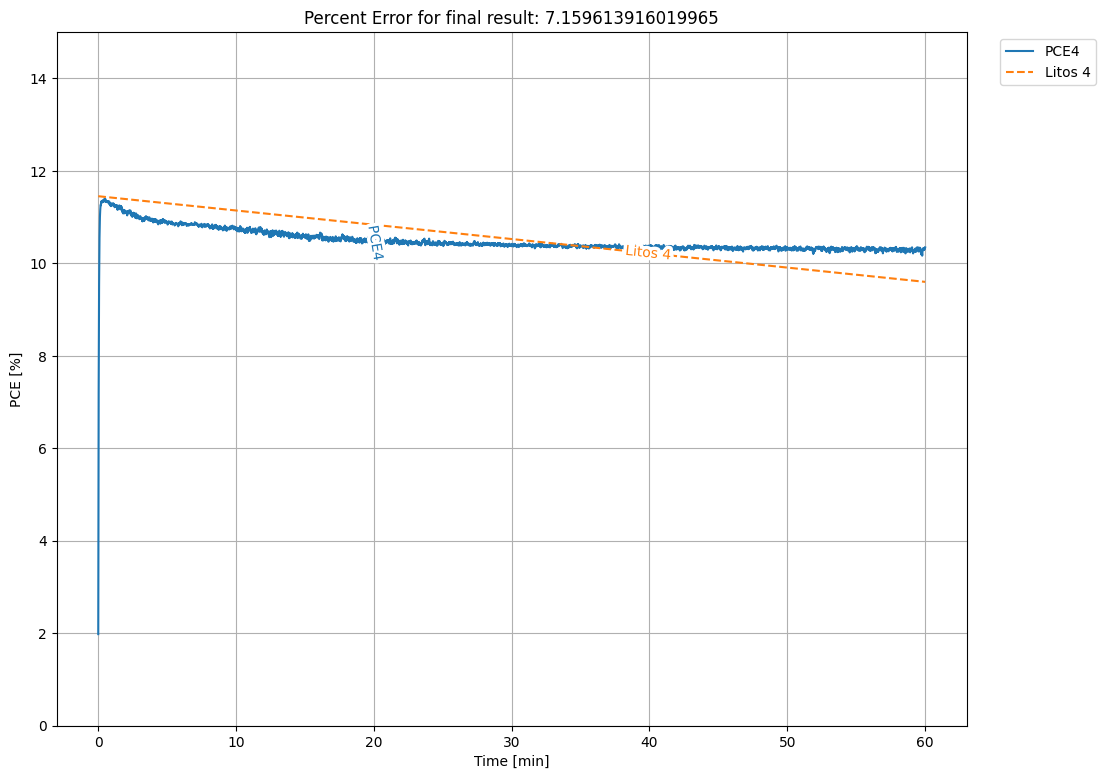

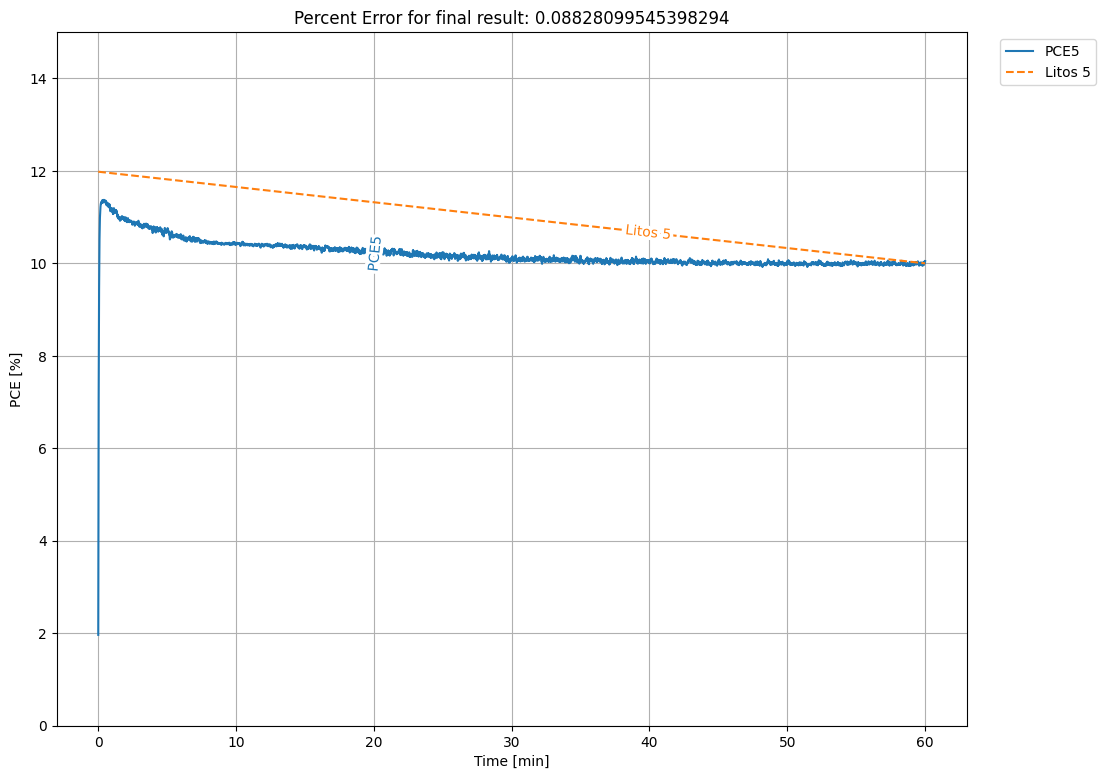

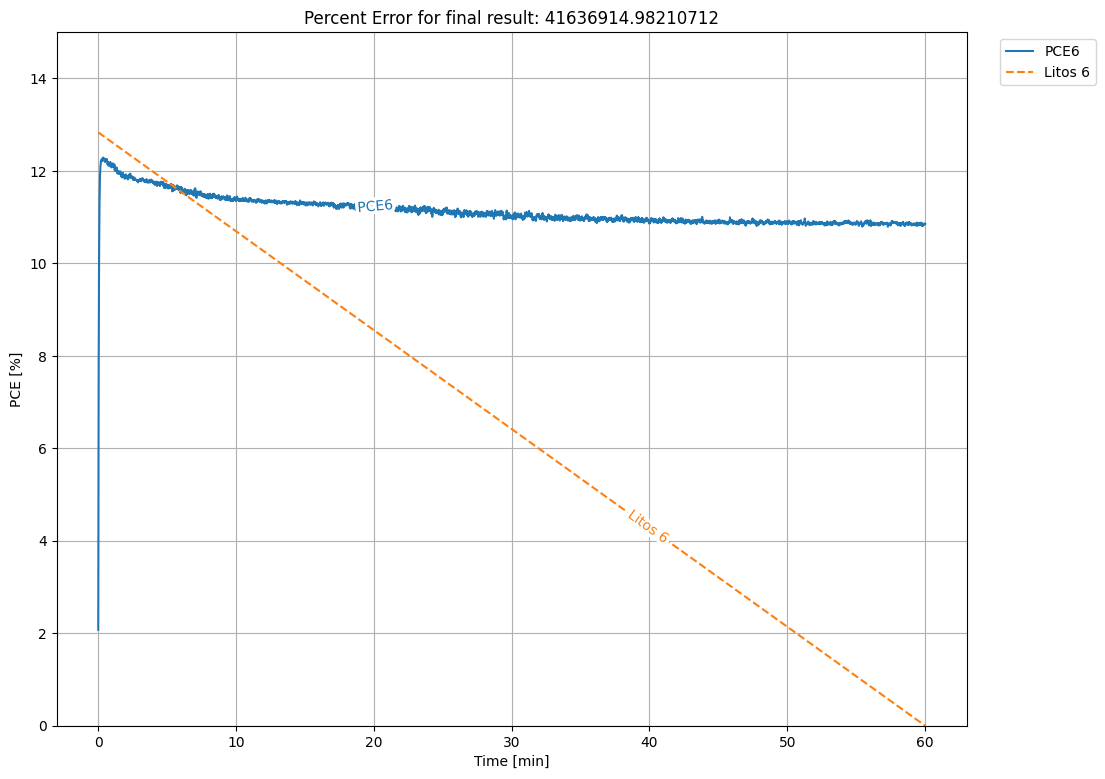

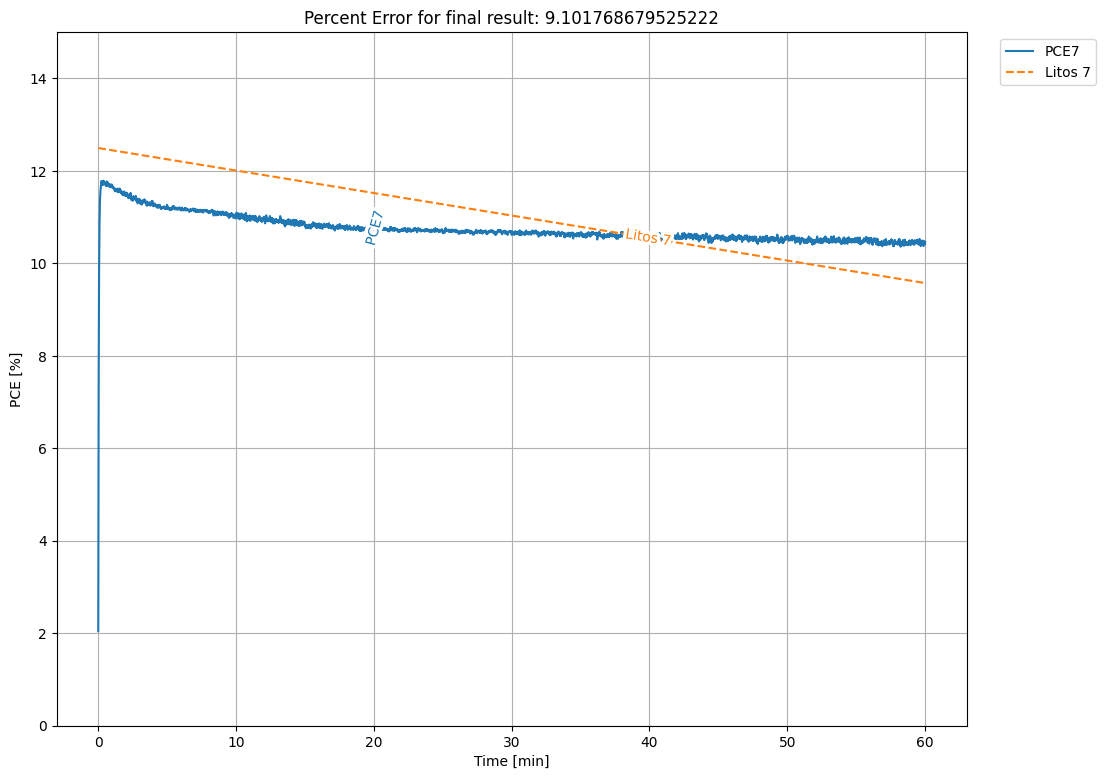

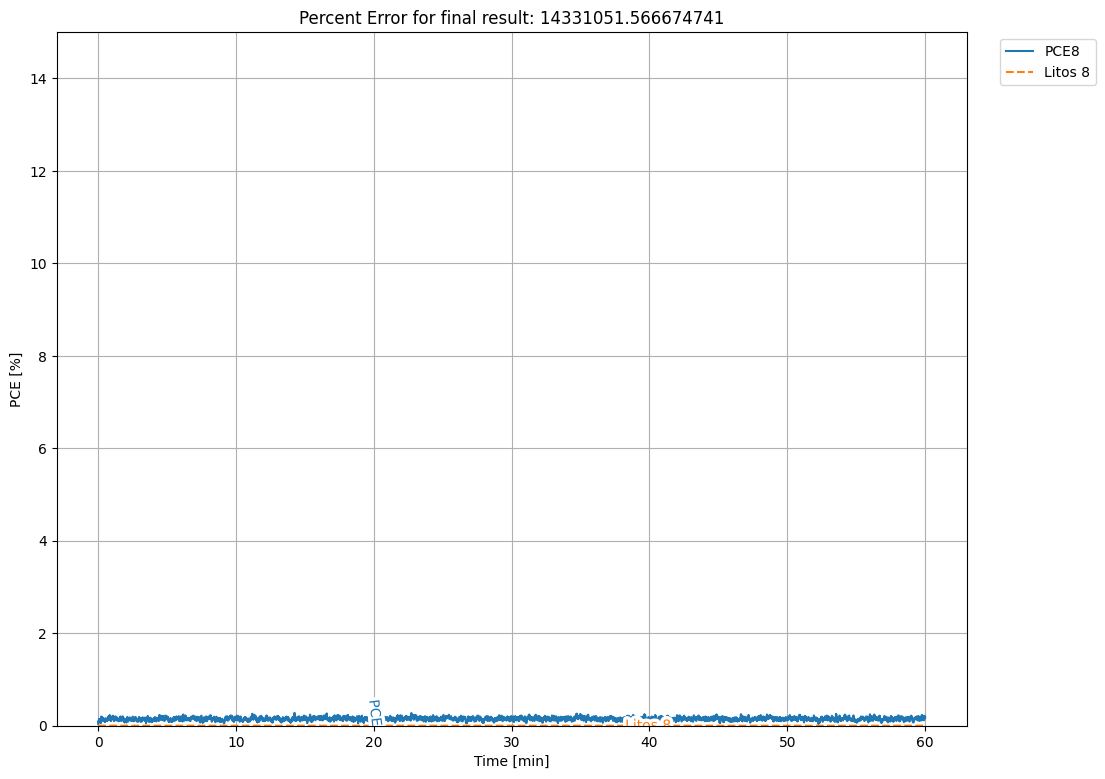

In [ ]:
errors = []
for i in range(8):
    plt.figure(figsize=plot_size)
    plt.ylim(bottom = -0, top = max_pce)
    plt.xlabel('Time [min]')
    plt.grid()

    plt.ylabel('PCE [%]')
    plt.subplots_adjust(left=0.086,
                        bottom=0.06,
                        right=0.844,
                        top=0.927,
                        wspace=0.2,
                        hspace=0.2)


    lineName = "PCE" + str(i + 1)
    # print(np.array(pce_list[i]))
    plt.plot(time,data[:,i], label = lineName)
    if i < len(litos_beginning_avg) and i < len(litos_ending_avg):
        # Calculate straight line
        y_values = [
            litos_beginning_avg[i],
            litos_ending_avg[i]
        ]
        x_values = [time[0], time[-1]]
        plt.plot(x_values, y_values, linestyle="--", label=f"Litos {i + 1}")

    last_portion = data[:,i][99*len(data[:,i]) // 100:]
    average_last_ss = np.mean(last_portion)

    percent_error = abs(average_last_ss - litos_ending_avg[i]) / abs(litos_ending_avg[i]) * 100
    errors.append(percent_error)

    labelLines(plt.gca().get_lines(), zorder=2.5)
    plt.title("Percent Error for final result: "+ str(percent_error))
    plt.legend(bbox_to_anchor=(1.15, 1))


for idx, i in enumerate(errors):
    print(idx+1, i)

11.980489822356686
10.445676157590675
11.818839911303405
11.451331187836963
11.981287720383836
12.83199561297592
12.493401470866804
2.1745197361680322e-05
nan
11.2520239349781
8.896264341297515
10.04067553057723
9.59906903408312
9.99953655116765
2.6051065573770492e-05
9.573134899719518
1.1501721311475273e-06
nan


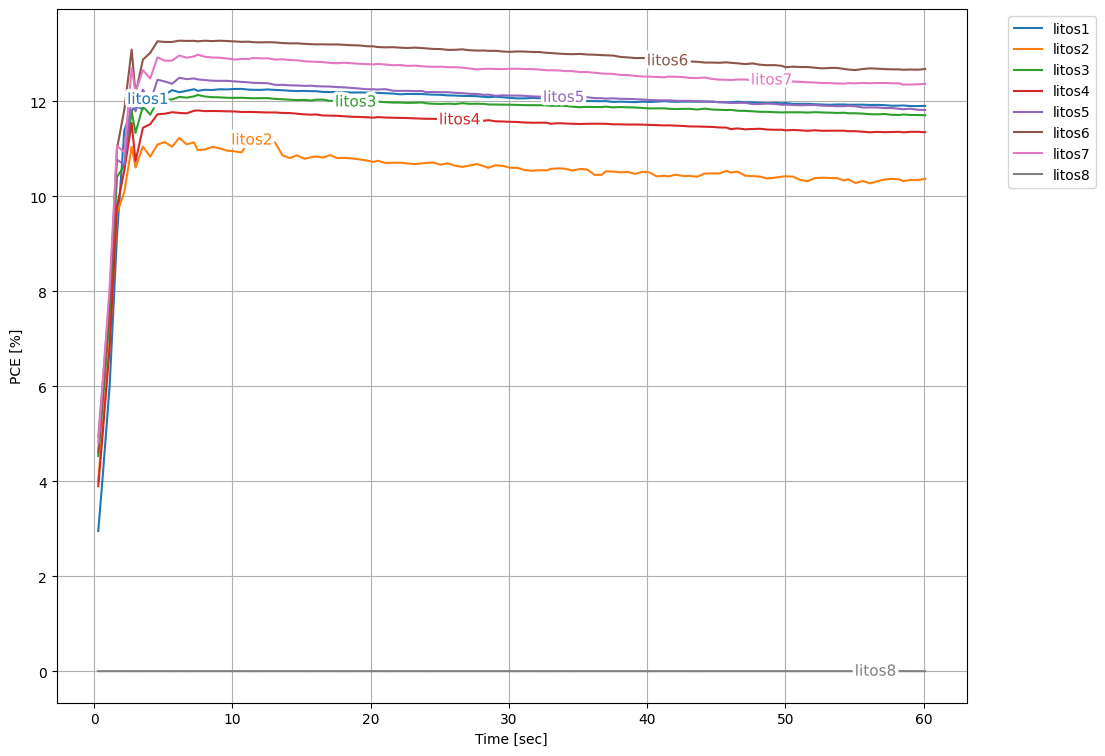

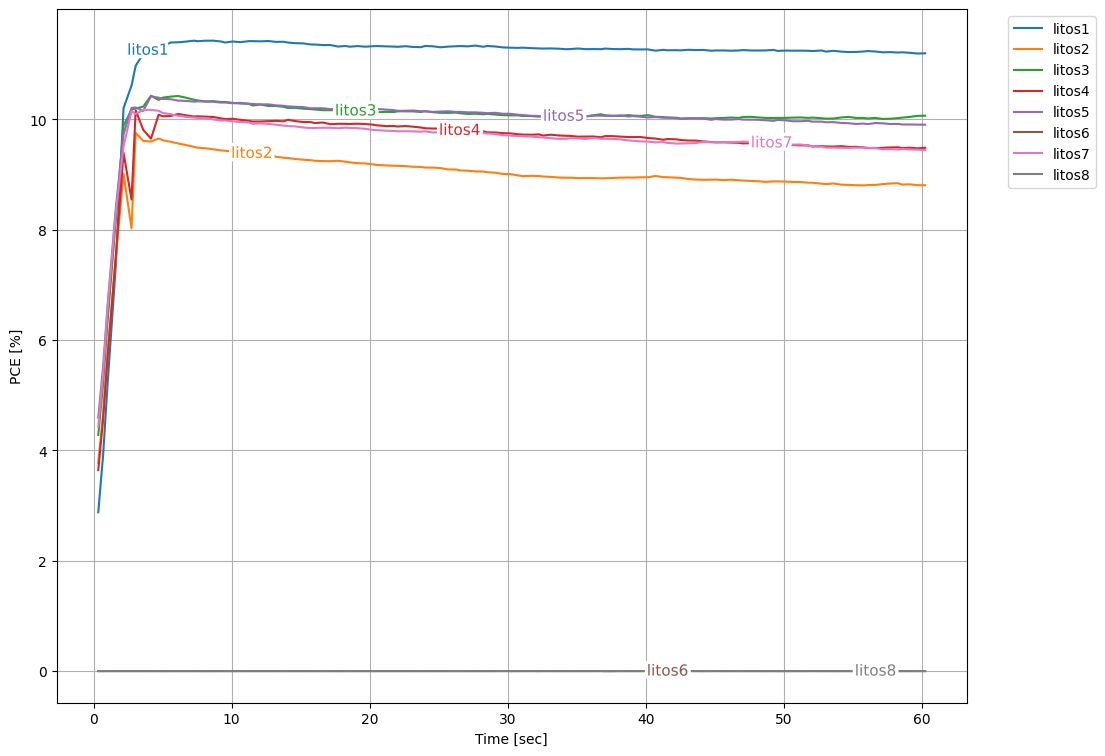

In [ ]:
def plot_litos_only(litos_directory, pattern):
    # litos_directory = ""

    all_files = []

    if litos_directory != "":
        for root, dirs, files in os.walk(litos_directory):
            for file in files:
                if file.endswith('.csv'):
                    file_path = os.path.join(root, file)
                    all_files.append(file_path)


    litos_pce = []
    litos_time = []

    # Process each file
    for file_path in all_files:
        if pattern in file_path:
            try:
                data = np.genfromtxt(
                    file_path,
                    delimiter=',',
                    comments='#',
                    skip_header=0,
                    encoding='cp1252'  # Specify the correct encoding
                )
                pce = (data[:, 1] * data[:, 2] /1000) / (0.1*0.128)*100
                # data_with_pce= np.column_stack((data, pce))
                litos_time.append(data[:,0])
                litos_pce.append(pce)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

    litos_pce = litos_pce[::-1]
    litos_time = litos_time[::-1]


    plt.figure(figsize=plot_size)
    plt.xlabel('Time [sec]')
    plt.grid()

    plt.ylabel('PCE [%]')
    plt.subplots_adjust(left=0.086,
                        bottom=0.06,
                        right=0.844,
                        top=0.927,
                        wspace=0.2,
                        hspace=0.2)

    errors = []

    for i in range(8):
        if litos_time:
            plt.plot(litos_time[i], litos_pce[i], label = "litos" + str(i+1))
            second_half_litos = litos_pce[i][len(litos_pce[i]) // 2:]
            average_second_half_litos = np.mean(second_half_litos)
            print(average_second_half_litos)

    print(np.mean(errors))

    lines = plt.gca().get_lines()
    x_min, x_max = plt.xlim()
    num_lines = len(lines)
    xvals = np.linspace(x_min + 0.1 * (x_max - x_min), x_max - 0.1 * (x_max - x_min), num_lines)
    bold_font = FontProperties(weight='medium')
    labelLines(
        lines,
        xvals=xvals,
        zorder=2.5,
        align=False,
        fontsize=11,
        fontproperties=bold_font
    )
    plt.legend(bbox_to_anchor=(1.15, 1))
plot_litos_only(r"C:\Users\achen\Dropbox\code\Stability-Setup\data\2024-11-06 --litos vs stability setup long test\nov6_2024 test 1\devices", "_3_0")
plot_litos_only(r"C:\Users\achen\Dropbox\code\Stability-Setup\data\2024-11-06 --litos vs stability setup long test\nov6_2024 test 1\devices", "_7_0")